# SVM with sigmoid kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)
* coef0 (default 0.0)

Sigmoid kernel function: $(\tanh(\gamma \langle x,x'\rangle + coef0))$

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['9058', '13003', '9074', '11244', '9270']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_data(s, data_dir='data/INDEX/', cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 9058: 9332
Testing set length for 9058: 3110
Cross-validation set length for 9058: 3110
Training set length for 13003: 7755
Testing set length for 13003: 2584
Cross-validation set length for 13003: 2584
Training set length for 9061: 10347
Testing set length for 9061: 3449
Cross-validation set length for 9061: 3449
Training set length for 9074: 8596
Testing set length for 9074: 2864
Cross-validation set length for 9074: 2864
Training set length for 11244: 10512
Testing set length for 11244: 3503
Cross-validation set length for 11244: 3503
Training set length for 9270: 8385
Testing set length for 9270: 2795
Cross-validation set length for 9270: 2795
Training set length for 9064: 10606
Testing set length for 9064: 3535
Cross-validation set length for 9064: 3535


In [3]:
dfs[stocks[0]].head()

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-16 14:02:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1917.0, 4920.0), (1917.5, 9151.0), (1918.0, ...",1916.0,1917.0,1916.50,4920.0,4181.0,1.0,-0.081200
2013-09-16 14:03:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1917.0, 1378.0), (1917.5, 6515.0), (1918.0, ...",1916.5,1917.0,1916.75,1378.0,96.0,0.0,-0.869742
2013-09-16 14:04:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1916.5, 2428.0), (1917.0, 7498.0), (1917.5, ...",1915.5,1916.5,1916.00,2428.0,3568.0,1.0,0.190127
2013-09-16 14:05:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1916.5, 900.0), (1917.0, 5990.0), (1917.5, 8...",1916.0,1916.5,1916.25,900.0,3648.0,1.0,0.604222
2013-09-16 14:06:00,"[(1000.0, 400.0), (1260.0, 400.0), (1350.0, 50...","[(1917.0, 2012.0), (1917.5, 9613.0), (1918.0, ...",1916.0,1917.0,1916.50,2012.0,5083.0,1.0,0.432840


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0, decision_function_shape='ovr'):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0, 
                  decision_function_shape=decision_function_shape)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults for parameters C and gamma.

Next we will choose parameter coef0 for SVM with gamma and C set to the best values we got.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

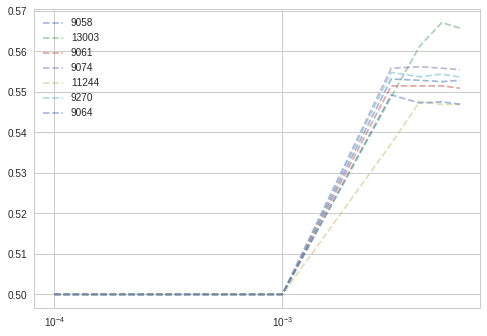

In [5]:
cs = [0.0001, 0.001, 0.003, 0.004, 0.005, 0.006]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'sigmoid', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

Choice of parameter C should be small - less than 0.1

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9058 the best is 0.003
For 13003 the best is 0.005
For 9061 the best is 0.003
For 9074 the best is 0.004
For 11244 the best is 0.004
For 9270 the best is 0.003
For 9064 the best is 0.003


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For three stocks **10795**, **12098** and **11618** it can affect the prediction by 0.1, for the rest the difference is less.

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9058 the diff between best and worst 0.05320797265459554
For 13003 the diff between best and worst 0.06712510959849893
For 9061 the diff between best and worst 0.05149972426594218
For 9074 the diff between best and worst 0.05621508379888274
For 11244 the diff between best and worst 0.04764491655208425
For 9270 the diff between best and worst 0.054839811473025746
For 9064 the diff between best and worst 0.04928000809238631


### Gamma

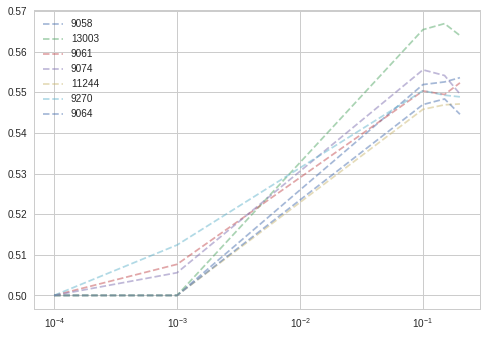

In [8]:
gammas = [0.0001, 0.001, 0.1, 0.15, 0.2]

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'sigmoid', gamma=g)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.5)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9058 the best is 0.2
For 13003 the best is 0.15
For 9061 the best is 0.2
For 9074 the best is 0.1
For 11244 the best is 0.2
For 9270 the best is 0.1
For 9064 the best is 0.15


##### Influence of gamma

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9058 the diff between best and worst 0.053588505267894826
For 13003 the diff between best and worst 0.06689335680309427
For 9061 the diff between best and worst 0.052312803475594194
For 9074 the diff between best and worst 0.05551675977653625
For 11244 the diff between best and worst 0.04711731605372438
For 9270 the diff between best and worst 0.050380116180464785
For 9064 the diff between best and worst 0.048348487351164704


### Coef0

For sigmoid kernel we use function:
$(\tanh(\gamma \langle x,x'\rangle + r))$, where r is specified by coef0.

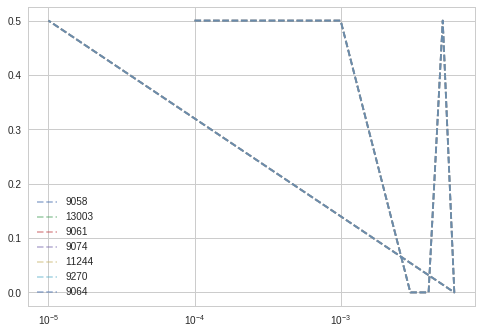

In [11]:
coeffs = [0.00001, 0.0001, 0.001, 0.005]

df_coefs = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_coef = pd.DataFrame(index=cs)
    df_coef['roc'] = np.zeros(len(df_coef))
    for c in coeffs:
        reg_svm = svm_classification(dfs[s], 'sigmoid', coef0=c, C=df_css[s]['roc'].idxmax(), 
                                     gamma=df_gammas[s]['roc'].idxmax())
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_coef.loc[c] = logit_roc_auc
    plt.plot(df_coef, linestyle='--', label=s, marker='x', alpha=0.5)
    df_coefs[s] = df_coef

plt.legend()

##### Best values of coef0

In [12]:
for s in stocks:
    idx = df_coefs[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 9058 the best is 0.0001
For 13003 the best is 0.0001
For 9061 the best is 0.0001
For 9074 the best is 0.0001
For 11244 the best is 0.0001
For 9270 the best is 0.0001
For 9064 the best is 0.0001


##### Influence of coef0

In [13]:
for s in stocks:
    err_max = df_coefs[s]['roc'].max()
    err_min = df_coefs[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 9058 the diff between best and worst 0.5
For 13003 the diff between best and worst 0.5
For 9061 the diff between best and worst 0.5
For 9074 the diff between best and worst 0.5
For 11244 the diff between best and worst 0.5
For 9270 the diff between best and worst 0.5
For 9064 the diff between best and worst 0.5


#### Best params so far

In [14]:
print(s, '\t', 'C', '\t', 'gamma', '\t', 'coef0')
    
for s in stocks:
    print(s, '\t', df_css[s]['roc'].idxmax(), '\t', df_gammas[s]['roc'].idxmax(), 
          '\t', df_coefs[s]['roc'].idxmax())

9064 	 C 	 gamma 	 coef0
9058 	 0.003 	 0.2 	 0.0001
13003 	 0.005 	 0.15 	 0.0001
9061 	 0.003 	 0.2 	 0.0001
9074 	 0.004 	 0.1 	 0.0001
11244 	 0.004 	 0.2 	 0.0001
9270 	 0.003 	 0.1 	 0.0001
9064 	 0.003 	 0.15 	 0.0001


# Results

We compare reults of SVMs with the best choices of parameter against the logistic regression and SVM with defaults.

We will use naive approach - for each stock we will just pick the best values we found in the previous section.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set. The **coef0** parameter "depend" of the choice of the rest of parameters.

In [15]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['sigmoid-default'] = np.zeros(len(stocks))
df_results['sigmoid-tunned'] = np.zeros(len(stocks))

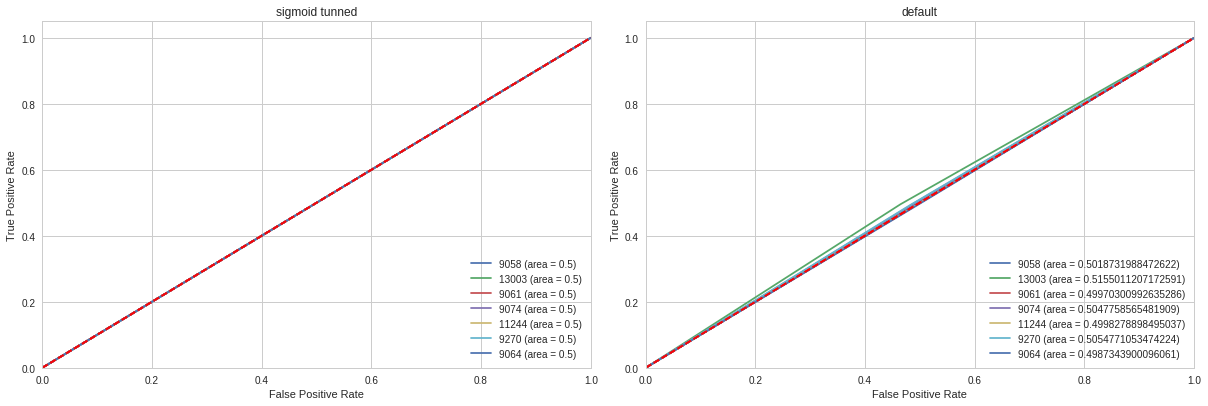

In [19]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(
        dfs[s], 'sigmoid', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax(),
        coef0=df_coefs[s]['roc'].idxmax())
    score = lob.plot_roc(df_test, reg_svm, stock=s, title='sigmoid tunned')
    df_results['sigmoid-tunned'][s] = score

plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'sigmoid')
    score = lob.plot_roc(df_test, reg_svm, stock=s, title='default')
    df_results['sigmoid-default'][s] = score
    
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

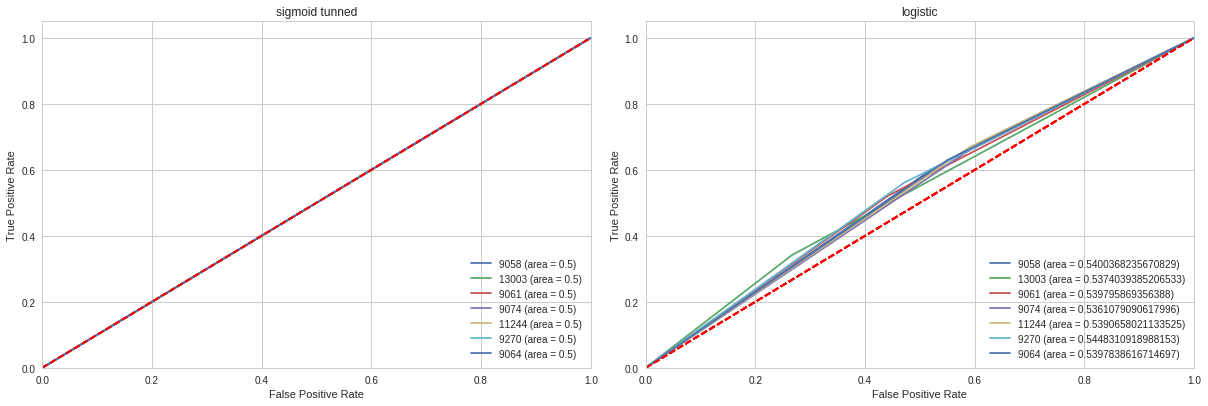

In [20]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(
        dfs[s], 'sigmoid', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax(),
        coef0=df_coefs[s]['roc'].idxmax())
    score = lob.plot_roc(df_test, reg_svm, stock=s, title='sigmoid tunned')
    df_results['sigmoid-tunned'][s] = score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    score = lob.plot_roc(df_test, reg_log, stock=s, title='logistic')
    df_results['logistic'][s] = score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [30]:
df_results

,logistic,sigmoid-default,sigmoid-tunned
9058,0.540037,0.501873,0.5
13003,0.537404,0.515501,0.5
9061,0.539796,0.499703,0.5
9074,0.536108,0.504776,0.5
11244,0.539066,0.499828,0.5
9270,0.544831,0.505477,0.5
9064,0.539784,0.498734,0.5


In [24]:
best_c = {}
best_g = {}
best_coef = {}
best_score = {}

for s in stocks:
    print(s)
    best_score[s] = 0
    best_c[s] = -1
    best_g[s] = -1
    best_coef[s] = -1
    for c in cs:
        for g in gammas:
            for coef in coeffs:
                reg_svm = svm_classification(dfs[s], 'sigmoid', C=c, gamma=g, coef0=coef)
                prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
                score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
                if score > best_score[s]:
                    best_c[s] = c
                    best_g[s] = g
                    best_coef[s] = coef
                    best_score[s] = score

9058
13003
9061
9074
11244
9270
9064


In [31]:
df_bests = pd.DataFrame(index=stocks)
df_bests['gamma'] = np.ones(len(stocks))
df_bests['c'] = np.ones(len(stocks))
df_bests['coef'] = np.ones(len(stocks))
df_bests['score'] = np.ones(len(stocks))
df_bests['logistic-score'] = df_results['logistic']
for s in stocks:
    df_bests['gamma'][s] = best_g[s]
    df_bests['c'][s] = best_c[s]
    df_bests['coef'][s] = best_coef[s]
    df_bests['score'][s] = best_score[s]
df_bests

,gamma,c,coef,score,logistic-score
9058,0.0001,0.0001,0.00001,0.500000,0.540037
13003,0.0001,0.0001,0.00001,0.500000,0.537404
9061,0.2000,0.0060,0.00001,0.520498,0.539796
9074,0.2000,0.0060,0.00001,0.527584,0.536108
11244,0.0001,0.0001,0.00001,0.500000,0.539066
9270,0.2000,0.0060,0.00001,0.524707,0.544831
9064,0.2000,0.0060,0.00001,0.507694,0.539784


# Conclusions

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>